In [37]:
# imports
import glob
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes.utils.data_classes import RadarPointCloud

In [38]:
# basic config and variables
_VERSION = 'v1.0-mini'
_DATAROOT = '/home/valerius/data/sets/nuscenes'

nusc = NuScenes(version=_VERSION, dataroot=_DATAROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.405 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [39]:
# get all the point cloud files

def get_all_radar_file_paths() -> list:
    """get the absolute file paths for all radar sample binaries."""
    return glob.glob(f'{_DATAROOT}/samples/RADAR_*/*.pcd')

# determine the first listed radar file as testfile
test_pcd_file = get_all_radar_file_paths()[0]

In [40]:
def read_coordinates_and_velocities_from_pcd(nusc_filepath: str):
    points =  RadarPointCloud.from_file(nusc_filepath).points
    x = points[0]
    y = points[1]
    vx_comp = points[8]
    vy_comp = points[9]

    return {
        'file': nusc_filepath,
        'x': x,
        'y': y,
        'vx_comp': vx_comp,
        'vy_comp': vy_comp,
        'v_comp': (vx_comp ** 2 + vy_comp ** 2) ** 0.5
    }


result = read_coordinates_and_velocities_from_pcd(test_pcd_file)
pprint(result)

{'file': '/home/valerius/data/sets/nuscenes/samples/RADAR_FRONT_LEFT/n008-2018-08-01-15-16-36-0400__RADAR_FRONT_LEFT__1533151616430028.pcd',
 'v_comp': array([4.78422981e-02, 2.27983813e-03, 7.43984423e-02, 6.49649119e-02,
       1.07033265e-01, 9.34026103e-03, 6.85211698e-02, 1.66588552e-02,
       9.98121273e-02, 1.54160111e-01, 1.05406475e-01, 7.37046146e-02,
       4.43869586e-02, 1.36809555e-01, 2.74166566e-02, 8.40879019e-02,
       2.02974639e-02, 9.19832648e-02, 1.20565177e-02, 7.55414863e-02,
       9.80957729e-03, 4.48503813e-04, 1.49008865e-01, 3.77898153e-02,
       2.25152199e-01, 1.77112591e-02, 1.83527954e-01, 1.93922913e-01,
       1.74272602e-01, 6.69303557e-02, 1.85249329e-03, 1.69586504e-02,
       6.50596619e-03, 4.95672761e-03, 5.51046667e-02, 2.65684329e-02,
       4.51780948e-02, 4.56685834e-02, 7.39721326e-02, 1.28001131e-01,
       4.72043826e-02, 6.43596876e-03, 1.30029716e+00, 1.25103778e+00,
       6.20066115e-03, 1.18612408e+00, 7.88750297e-02, 6.36742760e-

In [41]:
# help(RadarPointCloud)

# nusc.sample_data[0]

# nusc.get('sample', '39586f9d59004284a7114a68825e8eec')

sc = nusc.scene[0]

sc

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [42]:
# extract samples


def extract_samples_from_scene(scene: dict):
    """extract all the samples related to the given scene."""
    first_sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = list()

    fst = nusc.get('sample', first_sample_token)
    next_token = fst['next']
    while True:
        current = nusc.get('sample', next_token)
        samples.append(current)
        next_token = current['next']
        if next_token == last_sample_token:
            return samples
    # return first_sample_token, last_sample_token, scene

samples_from_scene = extract_samples_from_scene(sc)

def extract_channel_from_file(channel: str):
    filename = nusc.get('sample_data', channel)['filename']
    filename = f'{_DATAROOT}/{filename}'
    return read_coordinates_and_velocities_from_pcd(filename)

def convert_binary_data_to_coordinates_and_velocity(sample: dict):
    data = sample['data']
    return {
     'RADAR_FRONT' : extract_channel_from_file(data['RADAR_FRONT']),
     'RADAR_FRONT_LEFT' : extract_channel_from_file(data['RADAR_FRONT_LEFT']),
     'RADAR_FRONT_RIGHT' : extract_channel_from_file(data['RADAR_FRONT_RIGHT']),
     'RADAR_BACK_LEFT' : extract_channel_from_file(data['RADAR_BACK_LEFT']),
     'RADAR_BACK_RIGHT' : extract_channel_from_file(data['RADAR_BACK_RIGHT']),
    }

scene_in_sample_data = [convert_binary_data_to_coordinates_and_velocity(sc) for sc in samples_from_scene]


In [43]:
# sc
def get_ego_pose_from_timestamp(timestamp: int) -> dict:
    return [s for s  in nusc.ego_pose if s['timestamp'] == timestamp][0]

ego_poses_from_scene = [get_ego_pose_from_timestamp(s['timestamp']) for s in extract_samples_from_scene(sc)]

coordinates_from_scene = [(c[0],c[1]) for c in [s['translation'] for s in ego_poses_from_scene]]

coordinates_from_scene

[(409.7431520488096, 1176.6769733781416),
 (408.101879146712, 1172.1515777892457),
 (406.7260055966978, 1168.2112865775816),
 (405.40940618082874, 1164.3542269452469),
 (404.27766613575534, 1161.0501064609266),
 (403.1147868052399, 1157.5179992427084),
 (401.882035855894, 1153.723115401486),
 (400.84139513617623, 1150.4041654308548),
 (399.84353161665877, 1147.1735328106026),
 (399.0198373002425, 1144.398545717494),
 (398.16712901294835, 1141.370496193884),
 (397.4476741975414, 1138.4704918742955),
 (396.8835035523236, 1135.6564273770866),
 (396.4443552268204, 1132.6271305081405),
 (396.28709579417813, 1130.0546235114005),
 (396.3721334319953, 1127.5762883014086),
 (396.6816902790987, 1125.2563692026397),
 (397.1853086632334, 1123.0598472868774),
 (397.8606615606245, 1121.0773884177784),
 (398.7597041521511, 1119.1284635254908),
 (399.9076584877769, 1117.2088940698718),
 (401.0653931407355, 1115.6784191807697),
 (402.47435861332616, 1114.1490807505795),
 (404.11369592844784, 1112.67625

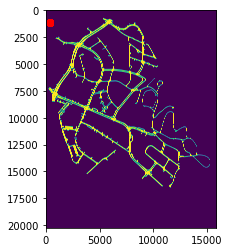

In [44]:
lt = sc['log_token']

mt = nusc.get('log', lt)['map_token']

mapfile = f"{_DATAROOT}/{nusc.get('map',mt)['filename']}"

im = plt.imread(mapfile)
implot = plt.imshow(im)

map_x = np.array([c[0] for c in coordinates_from_scene])
map_y = np.array([c[1] for c in coordinates_from_scene])
plt.scatter(x=map_x, y=map_y, c="r")

plt.show()

In [59]:
raw_data = [{
    'translation': np.array(s['translation']),
    'rotation': Quaternion(s['rotation']),
    } for s in ego_poses_from_scene]

trans = [transform_matrix(e['translation'], e['rotation']) for e in raw_data]

trans * np.array([[c[0], c[1], 0.0] for c in coordinates_from_scene])

ValueError: operands could not be broadcast together with shapes (37,4,4) (37,3) 